In [1]:
import importlib

import matplotlib.pyplot as plt
import pandas as pd

from data.attribute import YEAR_ATTR, IS_PERMANENT_RESIDENT_ATTR, IS_CITIZEN_ATTR, AGE_ATTR, POPULATION_ATTR, SEX_ATTR, \
    COMMUNE_SIZE_ATTR
from data.error import finite_classical_error_margin, kish_effective_sample_size
from data.location import CANTON_ATTR
from utils.distribution import merge_proportional, total_variance_distance

In [2]:
from data.selects.source import get_fors_selects
from data.population import get_bfs_population_cga

selects_df = get_fors_selects()
population_df = get_bfs_population_cga()

In [3]:
year = selects_df[YEAR_ATTR].max()
selects_year_df = selects_df[selects_df[YEAR_ATTR] == year].dropna(axis=1, how='all')
population_year_df = population_df[(population_df[YEAR_ATTR] == year) & (population_df[IS_PERMANENT_RESIDENT_ATTR])]
electorate_year_df = population_year_df[(population_year_df[IS_CITIZEN_ATTR]) & (population_year_df[AGE_ATTR] >= 18)]

print(f'Year: {year}')
print(f'Number of selects respondents: {len(selects_year_df)}')
print(f'Population: {population_year_df[POPULATION_ATTR].sum()}')
print(f'Electorate: {electorate_year_df[POPULATION_ATTR].sum()}')

Year: 2019
Number of selects respondents: 6664
Population: 8606033
Electorate: 5291269


In [4]:
from data.location import load_cantons_metadata

cantons_metadata = load_cantons_metadata()
canton_names = cantons_metadata.set_index(CANTON_ATTR).cantonAbbreviation

In [5]:
import data.selects as selects_module

importlib.reload(selects_module)

corrected_selects_year_df = selects_module.post_process_selects(selects_year_df, electorate_year_df)

Age distribution TVD:
Selects                0.089583
Selects (corrected)    0.000046
Population             0.091028
dtype: float64


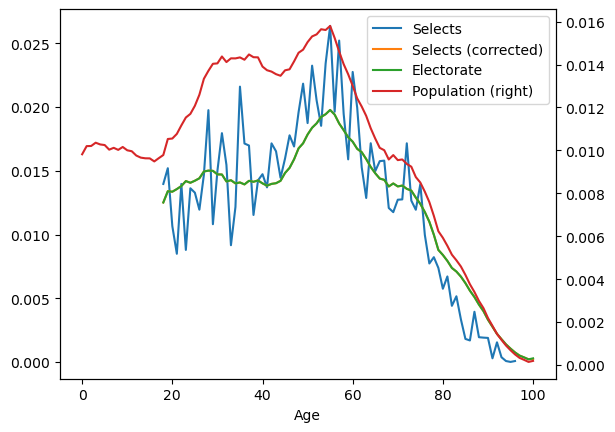

In [7]:
selects_age = selects_year_df.groupby(AGE_ATTR) \
    ['weighttot'].sum().rename('Selects')
corrected_selects_age = corrected_selects_year_df.groupby(AGE_ATTR) \
    ['weighttot'].sum().rename('Selects (corrected)')

electorate_age = electorate_year_df.groupby(AGE_ATTR)[POPULATION_ATTR].sum().rename('Electorate')
population_age = population_year_df.groupby(AGE_ATTR)[POPULATION_ATTR].sum().rename('Population')

merge_proportional(
    selects_age, corrected_selects_age, electorate_age, population_age
).sort_index().plot(secondary_y='Population')

# Calculate Total Variation Distance from electorate for all distributions
age_distribution = merge_proportional(selects_age, corrected_selects_age, electorate_age, population_age)
print('Age distribution TVD:')
print(total_variance_distance(age_distribution, 'Electorate'))

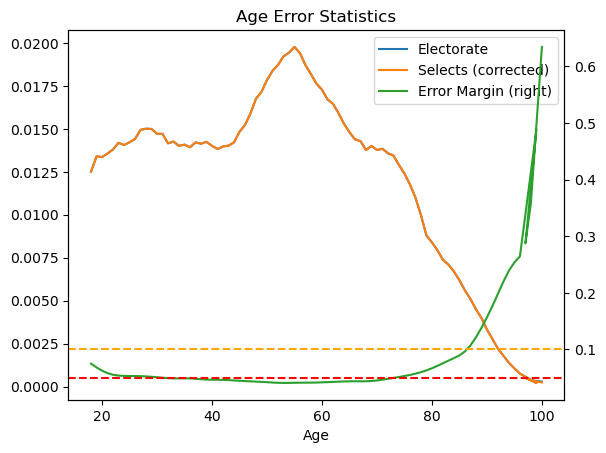

In [8]:
age_sample_count = corrected_selects_year_df.groupby(AGE_ATTR)['weighttot'] \
    .agg(kish_effective_sample_size).rename('Effective Sample Size')
age_error_margin = pd.concat([
    age_sample_count,
    electorate_age
], axis=1).apply(
    lambda x: finite_classical_error_margin(x['Effective Sample Size'], x['Electorate']), axis=1
).rename('Error Margin')

# Display age error statistics
age_error_stats = pd.concat([
    age_distribution[['Electorate', 'Selects (corrected)']],
    age_error_margin,
], axis=1).plot(secondary_y=['Error Margin'], title='Age Error Statistics')
plt.axhline(y=0.05, color='red', linestyle='--', label='5% Error Margin')
plt.axhline(y=0.1, color='orange', linestyle='--', label='50% Error Margin')

Sex distribution TVD:
Selects                0.002381
Selects (corrected)    0.000022
Population             0.017132
dtype: float64


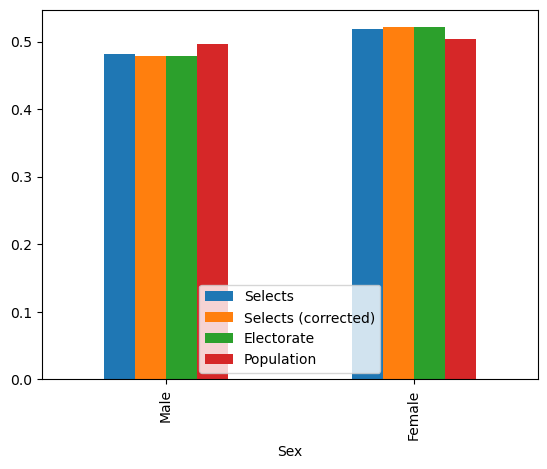

In [16]:
selects_sex = selects_year_df.groupby(SEX_ATTR, observed=True) \
    ['weighttot'].sum().rename('Selects')
corrected_selects_sex = corrected_selects_year_df.groupby(SEX_ATTR, observed=True) \
    ['weighttot'].sum().rename('Selects (corrected)')
electorate_sex = electorate_year_df.groupby(SEX_ATTR, observed=True)[POPULATION_ATTR].sum().rename('Electorate')
population_sex = population_year_df.groupby(SEX_ATTR, observed=True)[POPULATION_ATTR].sum().rename('Population')

sex_distribution = merge_proportional(
    selects_sex, corrected_selects_sex, electorate_sex, population_sex
)
sex_distribution.plot(kind='bar')
print('Sex distribution TVD:')
print(total_variance_distance(sex_distribution, 'Electorate'))

Sex error margins: Sex
Male      0.008757
Female    0.008677
Name: Error Margin, dtype: float64


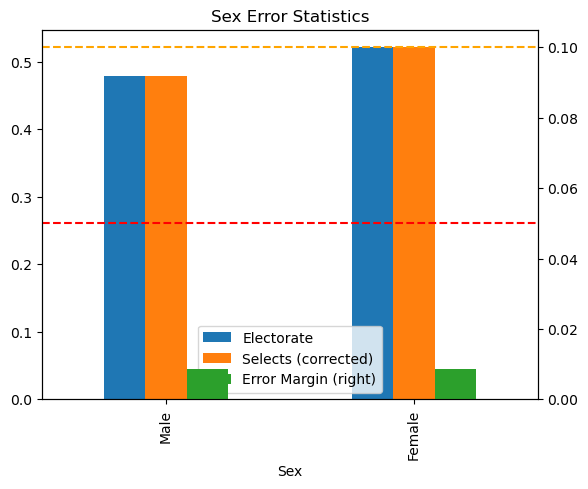

In [15]:
sex_sample_count = corrected_selects_year_df.groupby(SEX_ATTR, observed=True)['weighttot'] \
    .agg(kish_effective_sample_size).rename('Effective Sample Size')
sex_error_margin = pd.concat([
    sex_sample_count,
    electorate_sex
], axis=1).apply(
    lambda x: finite_classical_error_margin(x['Effective Sample Size'], x['Electorate']), axis=1
).rename('Error Margin')

pd.concat([
    sex_distribution[['Electorate', 'Selects (corrected)']],
    sex_error_margin,
], axis=1).plot(kind='bar', title='Sex Error Statistics', secondary_y=['Error Margin'])
plt.axhline(y=0.05, color='red', linestyle='--', label='5% Error Margin')
plt.axhline(y=0.1, color='orange', linestyle='--', label='10% Error Margin')
print("Sex error margins:", sex_error_margin)

Commune size distribution TVD:
Selects                0.024142
Selects (corrected)    0.019415
Population             0.032834
dtype: float64


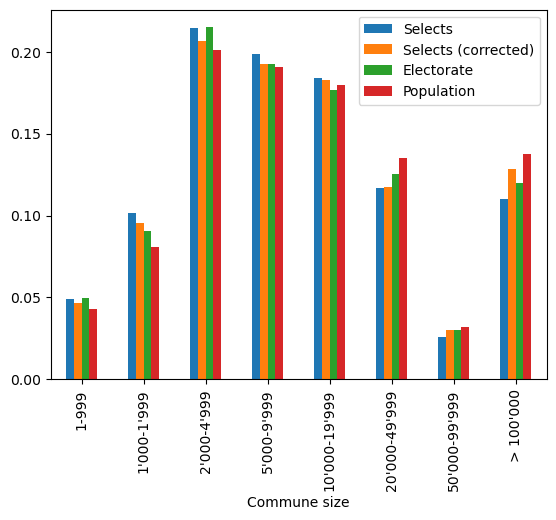

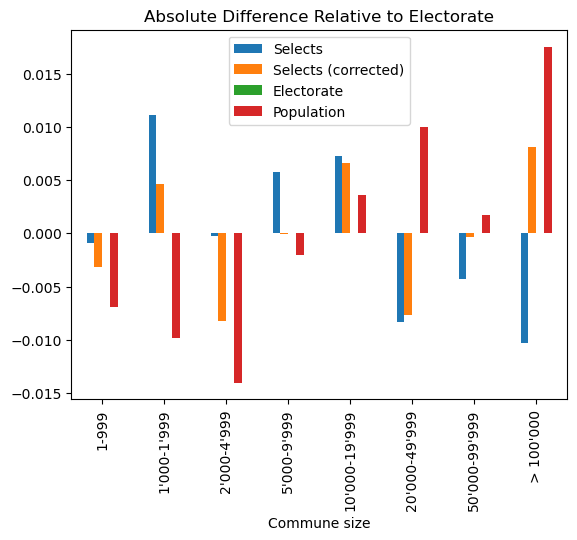

In [17]:
selects_commune_size = selects_year_df.groupby(COMMUNE_SIZE_ATTR, observed=True) \
    ['weighttot'].sum().rename('Selects')
corrected_selects_commune_size = corrected_selects_year_df.groupby(COMMUNE_SIZE_ATTR, observed=True) \
    ['weighttot'].sum().rename('Selects (corrected)')

electorate_commune_size = electorate_year_df.groupby(COMMUNE_SIZE_ATTR, observed=True) \
    [POPULATION_ATTR].sum().rename('Electorate')
population_commune_size = population_year_df.groupby(COMMUNE_SIZE_ATTR, observed=True) \
    [POPULATION_ATTR].sum().rename('Population')

commune_size_distribution = merge_proportional(
    selects_commune_size, corrected_selects_commune_size,
    electorate_commune_size, population_commune_size
).fillna(0)

commune_size_distribution.plot(kind='bar', xlabel='Commune size')
(commune_size_distribution.sub(commune_size_distribution['Electorate'], axis=0)).plot(
    kind='bar', xlabel='Commune size', title='Absolute Difference Relative to Electorate')
print('Commune size distribution TVD:')
print(total_variance_distance(commune_size_distribution, 'Electorate'))

Commune size error margins: Commune Size
1-999            0.029417
1'000-1'999      0.020681
2'000-4'999      0.014177
5'000-9'999      0.014599
10'000-19'999    0.014394
20'000-49'999    0.017214
50'000-99'999    0.038945
> 100'000        0.014648
Name: Error Margin, dtype: float64


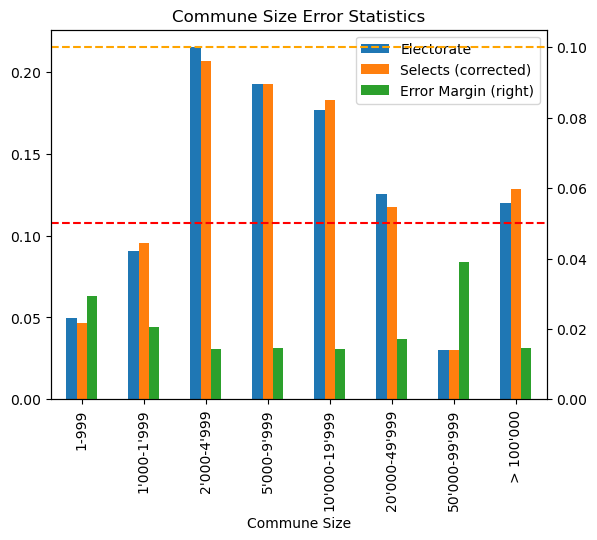

In [18]:
commune_size_sample_count = corrected_selects_year_df.groupby(COMMUNE_SIZE_ATTR, observed=True)[
    'weighttot'] \
    .agg(kish_effective_sample_size).rename('Effective Sample Size')
commune_size_error_margin = pd.concat([
    commune_size_sample_count,
    electorate_commune_size
], axis=1).apply(
    lambda x: finite_classical_error_margin(x['Effective Sample Size'], x['Electorate']), axis=1
).rename('Error Margin')

commune_size_error_stats = pd.concat([
    commune_size_distribution[['Electorate', 'Selects (corrected)']],
    commune_size_error_margin,
], axis=1).plot(kind='bar', title='Commune Size Error Statistics', secondary_y=['Error Margin'])
plt.axhline(y=0.05, color='red', linestyle='--', label='5% Error Margin')
plt.axhline(y=0.1, color='orange', linestyle='--', label='10% Error Margin')

print("Commune size error margins:", commune_size_error_margin)

Canton distribution TVD:
Selects                0.029631
Selects (corrected)    0.018028
Population             0.033669
dtype: float64


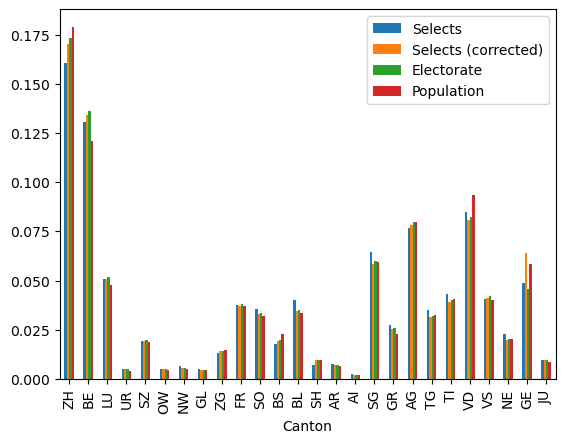

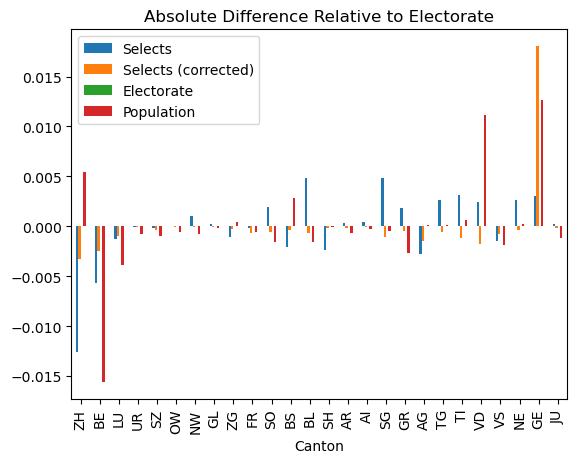

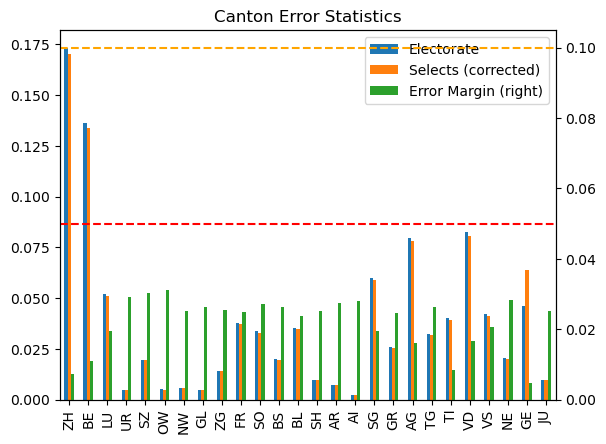

In [35]:
selects_canton_map = cantons_metadata.set_index(cantons_metadata.cantonAbbreviation.str.lower())[CANTON_ATTR]
selects_canton = selects_year_df.groupby('sg3', observed=True) \
    ['weighttot'].sum().rename('Selects').rename(selects_canton_map)
corrected_selects_canton = corrected_selects_year_df.groupby('sg3', observed=True) \
    ['weighttot'].sum().rename('Selects (corrected)').rename(selects_canton_map)

electorate_canton = electorate_year_df.groupby(CANTON_ATTR, observed=True) \
    [POPULATION_ATTR].sum().rename('Electorate')
population_canton = population_year_df.groupby(CANTON_ATTR, observed=True) \
    [POPULATION_ATTR].sum().rename('Population')

canton_distribution = merge_proportional(
    selects_canton, corrected_selects_canton,
    electorate_canton, population_canton
).fillna(0).rename(canton_names)

canton_distribution.plot(kind='bar', xlabel='Canton')
(canton_distribution.sub(canton_distribution['Electorate'], axis=0)).plot(
    kind='bar', xlabel='Canton', title='Absolute Difference Relative to Electorate'
)
print('Canton distribution TVD:')
print(total_variance_distance(canton_distribution, 'Electorate'))

canton_sample_count = corrected_selects_year_df.groupby('sg3', observed=True)['weightc'] \
    .agg(kish_effective_sample_size).rename('Effective Sample Size').rename(selects_canton_map)
canton_error_margin = pd.concat([
    canton_sample_count,
    electorate_canton
], axis=1).apply(
    lambda x: finite_classical_error_margin(x['Effective Sample Size'], x['Electorate']), axis=1
).rename('Error Margin').rename(canton_names)

canton_error_stats = pd.concat([
    canton_distribution[['Electorate', 'Selects (corrected)']],
    canton_error_margin,
], axis=1).plot(kind='bar', title='Canton Error Statistics', secondary_y=['Error Margin'])
plt.axhline(y=0.05, color='red', linestyle='--', label='5% Error Margin')
plt.axhline(y=0.1, color='orange', linestyle='--', label='10% Error Margin')
